In [1]:
import os

if os.name == 'nt':
    %env DOC=C:\Users\BK\Documents
else:
    %env DOC=/Users/muuzh/Documents

from AMI import automutual_info_single, automutual_info, automutual_info_k1

env: DOC=C:\Users\BK\Documents
C:\Users\BK\Documents\JIDT\infodynamics.jar


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
import seaborn as sns
import pandas as pd
import time
import itertools
import scipy.stats as stats
import jpype
import datasets as datasets

In [3]:
def SS_iter_surro(X, max_it=5000):
    N = len(X)

    r = np.random.permutation(X)

    c = np.sort(X)

    f_amp = np.abs(np.fft.fft(X))

    for i in range(max_it):
        R = np.fft.fft(r)
        phases = np.angle(R)
        s = np.real(np.fft.ifft(f_amp * np.exp(1j * phases)))

        k = np.argsort(s)
        r[k] = c

        if np.mean(np.abs(R - f_amp)) < 0.1 * np.max(X):
            print('ended early')
            break

    sur = s
    return sur


In [31]:
x_start = 0.1
series_length = 2200
tent_a_num = 100
tent_logistic_num = 100

param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
param_range_logistic = np.linspace(3.57, 4, tent_logistic_num)

tent_full_data = np.array([
    np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
    for mu in param_range_tent
])
logistic_full_data = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
    for r in param_range_logistic
])

# take the last 2000 points of each series the series as the actual data
tent_full_data = tent_full_data[:, 200:]
logistic_full_data = logistic_full_data[:, 200:]


In [32]:
result = SS_iter_surro(tent_full_data[-10])


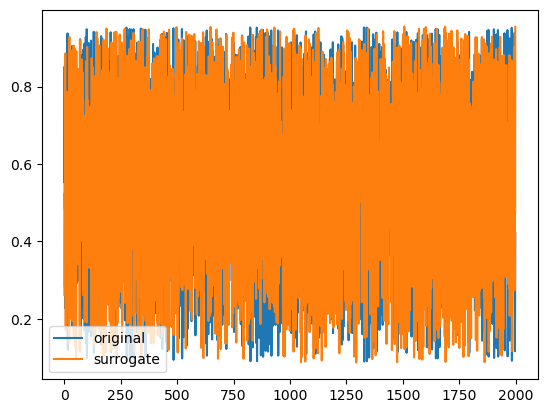

In [33]:
plt.plot(tent_full_data[-10])
plt.plot(result)
plt.legend(['original', 'surrogate'])
plt.show()

In [35]:
tentAMI1 = automutual_info(tent_full_data, 1, 3)
logisticAMI1 = automutual_info(logistic_full_data, 1, 3)

tentAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in tent_full_data
])
logisticAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in logistic_full_data
])


Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

In [36]:
tentLambdas = np.log(param_range_tent, where=param_range_tent > 0)
tentLambdas[np.where(param_range_tent <= 0)] = np.nan
tentChaoticIdx = np.where(tentLambdas > 0)

logisticLambdas =np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, param_range_logistic)
    ])
logisticChaoticIdx = np.where(logisticLambdas > 0)

tentParamRangeChaotic = param_range_tent[tentChaoticIdx]
tentAC1Chaotic = tentAC1[tentChaoticIdx]

logisticParamRangeChaotic = param_range_logistic[logisticChaoticIdx]
logisticAC1Chaotic = logisticAC1[logisticChaoticIdx]
tentAMI1Chaotic = tentAMI1[tentChaoticIdx]
logisticAMI1Chaotic = logisticAMI1[logisticChaoticIdx]


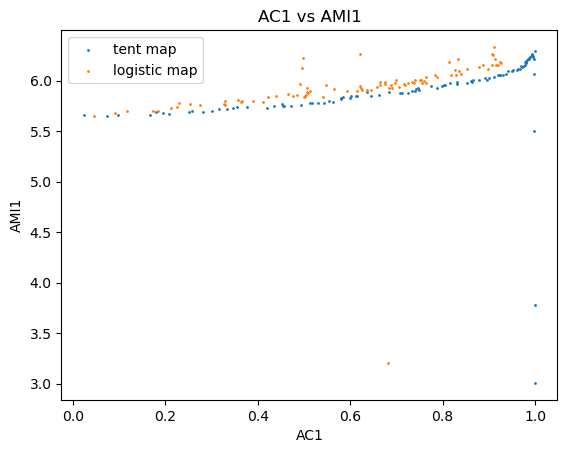

In [37]:
plt.figure()
plt.scatter(np.abs(tentAC1Chaotic), tentAMI1Chaotic, s=1)
plt.scatter(np.abs(logisticAC1Chaotic), logisticAMI1Chaotic, s=1)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("AC1 vs AMI1")
plt.legend(["tent map", "logistic map"])
plt.show()


In [39]:
# compute surrogates for the chaotic regions
tentSurrogates = np.array([SS_iter_surro(series, max_it=2000) for series in tqdm(tent_full_data)])
logisticSurrogates = np.array([SS_iter_surro(series, max_it=2000) for series in tqdm(logistic_full_data)])


  0%|          | 0/100 [00:00<?, ?it/s]

ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early


  0%|          | 0/100 [00:00<?, ?it/s]

In [42]:
tentSurrogatesAMI1 = automutual_info(tentSurrogates, 1, 3)
logisticSurrogatesAMI1 = automutual_info(logisticSurrogates, 1, 3)

tentSurrogatesAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in tentSurrogates
])
logisticSurrogatesAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in logisticSurrogates
])



Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

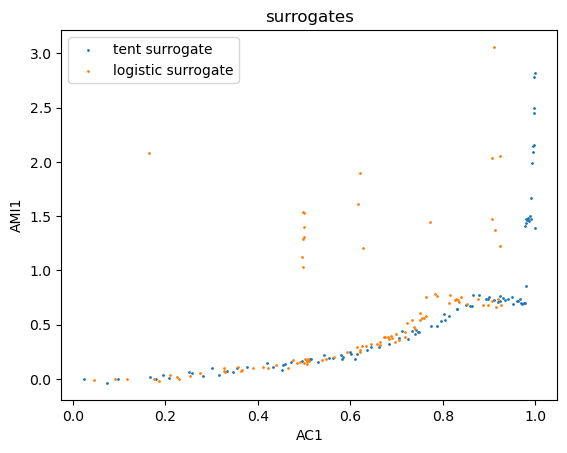

In [44]:
plt.figure()
plt.scatter(np.abs(tentSurrogatesAC1), tentSurrogatesAMI1, s=1)
plt.scatter(np.abs(logisticSurrogatesAC1), logisticSurrogatesAMI1, s=1)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("surrogates")
plt.legend(["tent surrogate", "logistic surrogate"])
plt.show()


In [45]:
a_num = 200

lag1para = np.linspace(0, 1, a_num)
ARpara = [np.r_[1, -arparams] for arparams in lag1para]
series_length = 2000

# Generate data
ARmatrix = np.array([ArmaProcess(ar, [1]).generate_sample(nsample=series_length) for ar in tqdm(ARpara)])

  0%|          | 0/200 [00:00<?, ?it/s]

In [46]:
ARmatrixAMI1 = automutual_info(ARmatrix, 1, 3)
ARmatrixAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in ARmatrix
])

Processing:   0%|          | 0/200 [00:00<?, ?it/s]

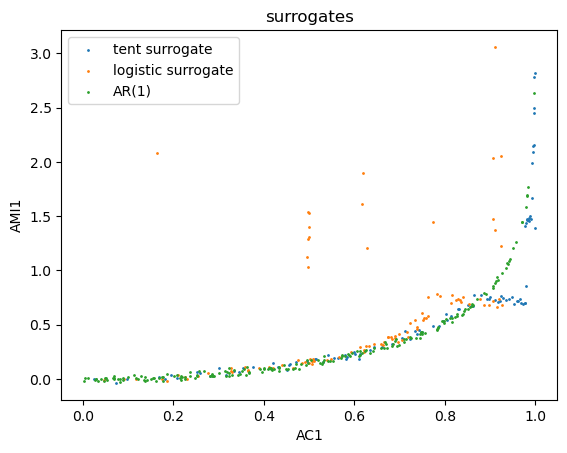

In [47]:
plt.figure()
plt.scatter(np.abs(tentSurrogatesAC1), tentSurrogatesAMI1, s=1)
plt.scatter(np.abs(logisticSurrogatesAC1), logisticSurrogatesAMI1, s=1)
plt.scatter(np.abs(ARmatrixAC1), ARmatrixAMI1, s=1)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("surrogates")
plt.legend(["tent surrogate", "logistic surrogate", "AR(1)"])
plt.show()

In [50]:
# book keeping
tentAC1_2000 = tentAC1
logisticAC1_2000 = logisticAC1

tentAMI1_2000 = tentAMI1
logisticAMI1_2000 = logisticAMI1


tentSurrogatesAC1_2000 = tentSurrogatesAC1
logisticSurrogatesAC1_2000 = logisticSurrogatesAC1


In [54]:
tentSurrogatesAMI1_2000 = tentSurrogatesAMI1
logisticSurrogatesAMI1_2000 = logisticSurrogatesAMI1

In [61]:
# now change the series length to 500 and repeat the above
x_start = 0.1
series_length = 500
tent_a_num = 100
tent_logistic_num = 100

param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
param_range_logistic = np.linspace(3.57, 4, tent_logistic_num)

tent_full_data = np.array([
    np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
    for mu in param_range_tent
])
logistic_full_data = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
    for r in param_range_logistic
])

# take the last 2000 points of each series the series as the actual data
tent_full_data = tent_full_data[:, 200:]
logistic_full_data = logistic_full_data[:, 200:]

tentAMI1 = automutual_info(tent_full_data, 1, 3)
logisticAMI1 = automutual_info(logistic_full_data, 1, 3)

tentAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in tent_full_data
])
logisticAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in logistic_full_data
])

tentLambdas = np.log(param_range_tent, where=param_range_tent > 0)
tentLambdas[np.where(param_range_tent <= 0)] = np.nan
tentChaoticIdx = np.where(tentLambdas > 0)

logisticLambdas =np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, param_range_logistic)
    ])
logisticChaoticIdx = np.where(logisticLambdas > 0)

tentParamRangeChaotic = param_range_tent[tentChaoticIdx]
tentAC1Chaotic = tentAC1[tentChaoticIdx]

logisticParamRangeChaotic = param_range_logistic[logisticChaoticIdx]
logisticAC1Chaotic = logisticAC1[logisticChaoticIdx]
tentAMI1Chaotic = tentAMI1[tentChaoticIdx]
logisticAMI1Chaotic = logisticAMI1[logisticChaoticIdx]

# book keeping
tentAC1_500 = tentAC1
logisticAC1_500 = logisticAC1

tentAMI1_500 = tentAMI1
logisticAMI1_500 = logisticAMI1

tentSurrogates_500 = np.array([SS_iter_surro(series, max_it=2000) for series in tqdm(tent_full_data)])
logisticSurrogates_500 = np.array([SS_iter_surro(series, max_it=2000) for series in tqdm(logistic_full_data)])


tentSurrogatesAMI1_500 = automutual_info(tentSurrogates_500, 1, 3)
logisticSurrogatesAMI1_500 = automutual_info(logisticSurrogates_500, 1, 3)

tentSurrogatesAC1_500 = np.array([
    acf(series, nlags=1)[1]
    for series in tentSurrogates_500
])
logisticSurrogatesAC1_500 = np.array([
    acf(series, nlags=1)[1]
    for series in logisticSurrogates_500
])



Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early


  0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

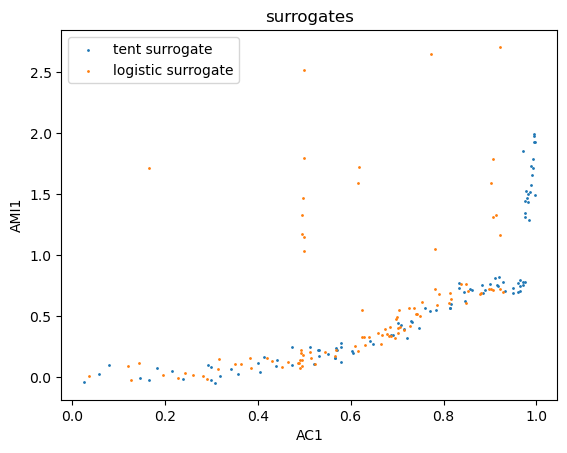

In [64]:
plt.figure()
plt.scatter(np.abs(tentSurrogatesAC1_500), tentSurrogatesAMI1_500, s=1)
plt.scatter(np.abs(logisticSurrogatesAC1_500), logisticSurrogatesAMI1_500, s=1)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("surrogates")
plt.legend(["tent surrogate", "logistic surrogate"])
plt.show()

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early


  0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

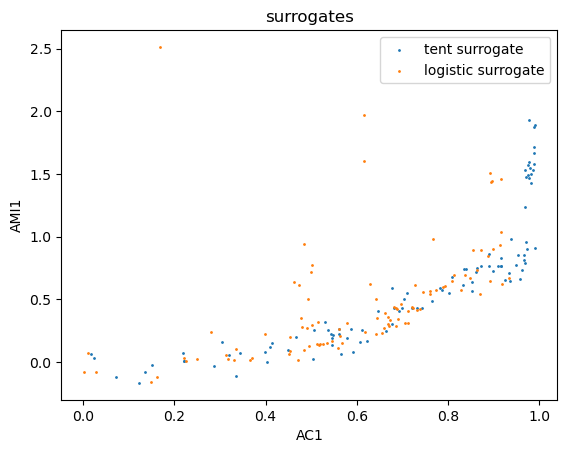

In [67]:
# now change the series length to 300 and repeat the above
x_start = 0.1
series_length = 300
tent_a_num = 100
tent_logistic_num = 100

param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
param_range_logistic = np.linspace(3.57, 4, tent_logistic_num)

tent_full_data = np.array([
    np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
    for mu in param_range_tent
])
logistic_full_data = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
    for r in param_range_logistic
])

tent_full_data = tent_full_data[:, 200:]
logistic_full_data = logistic_full_data[:, 200:]

tentAMI1 = automutual_info(tent_full_data, 1, 3)
logisticAMI1 = automutual_info(logistic_full_data, 1, 3)

tentAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in tent_full_data
])
logisticAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in logistic_full_data
])

tentLambdas = np.log(param_range_tent, where=param_range_tent > 0)
tentLambdas[np.where(param_range_tent <= 0)] = np.nan
tentChaoticIdx = np.where(tentLambdas > 0)

logisticLambdas =np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, param_range_logistic)
    ])
logisticChaoticIdx = np.where(logisticLambdas > 0)

tentParamRangeChaotic = param_range_tent[tentChaoticIdx]
tentAC1Chaotic = tentAC1[tentChaoticIdx]

logisticParamRangeChaotic = param_range_logistic[logisticChaoticIdx]
logisticAC1Chaotic = logisticAC1[logisticChaoticIdx]
tentAMI1Chaotic = tentAMI1[tentChaoticIdx]
logisticAMI1Chaotic = logisticAMI1[logisticChaoticIdx]

# book keeping
tentAC1_300 = tentAC1
logisticAC1_300 = logisticAC1

tentAMI1_300 = tentAMI1
logisticAMI1_300 = logisticAMI1

tentSurrogates_temp = np.array([SS_iter_surro(series, max_it=2000) for series in tqdm(tent_full_data)])
logisticSurrogates_temp = np.array([SS_iter_surro(series, max_it=2000) for series in tqdm(logistic_full_data)])


tentSurrogatesAMI1_300 = automutual_info(tentSurrogates_temp, 1, 3)
logisticSurrogatesAMI1_300 = automutual_info(logisticSurrogates_temp, 1, 3)

tentSurrogatesAC1_300 = np.array([
    acf(series, nlags=1)[1]
    for series in tentSurrogates_temp
])
logisticSurrogatesAC1_300 = np.array([
    acf(series, nlags=1)[1]
    for series in logisticSurrogates_temp
])



plt.figure()
plt.scatter(np.abs(tentSurrogatesAC1_300), tentSurrogatesAMI1_300, s=1)
plt.scatter(np.abs(logisticSurrogatesAC1_300), logisticSurrogatesAMI1_300, s=1)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("surrogates")
plt.legend(["tent surrogate", "logistic surrogate"])
plt.show()

In [68]:
# now change the series length to 800 and repeat the above
x_start = 0.1
series_length = 800
tent_a_num = 100
tent_logistic_num = 100

param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
param_range_logistic = np.linspace(3.57, 4, tent_logistic_num)

tent_full_data = np.array([
    np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
    for mu in param_range_tent
])
logistic_full_data = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
    for r in param_range_logistic
])

tent_full_data = tent_full_data[:, 200:]
logistic_full_data = logistic_full_data[:, 200:]

tentAMI1 = automutual_info(tent_full_data, 1, 3)
logisticAMI1 = automutual_info(logistic_full_data, 1, 3)

tentAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in tent_full_data
])
logisticAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in logistic_full_data
])

tentLambdas = np.log(param_range_tent, where=param_range_tent > 0)
tentLambdas[np.where(param_range_tent <= 0)] = np.nan
tentChaoticIdx = np.where(tentLambdas > 0)

logisticLambdas =np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, param_range_logistic)
    ])
logisticChaoticIdx = np.where(logisticLambdas > 0)

tentParamRangeChaotic = param_range_tent[tentChaoticIdx]
tentAC1Chaotic = tentAC1[tentChaoticIdx]

logisticParamRangeChaotic = param_range_logistic[logisticChaoticIdx]
logisticAC1Chaotic = logisticAC1[logisticChaoticIdx]
tentAMI1Chaotic = tentAMI1[tentChaoticIdx]
logisticAMI1Chaotic = logisticAMI1[logisticChaoticIdx]

# book keeping
tentAC1_800 = tentAC1
logisticAC1_800 = logisticAC1

tentAMI1_800 = tentAMI1
logisticAMI1_800 = logisticAMI1

tentSurrogates_temp = np.array([SS_iter_surro(series, max_it=2000) for series in tqdm(tent_full_data)])
logisticSurrogates_temp = np.array([SS_iter_surro(series, max_it=2000) for series in tqdm(logistic_full_data)])


tentSurrogatesAMI1_800 = automutual_info(tentSurrogates_temp, 1, 3)
logisticSurrogatesAMI1_800 = automutual_info(logisticSurrogates_temp, 1, 3)

tentSurrogatesAC1_800 = np.array([
    acf(series, nlags=1)[1]
    for series in tentSurrogates_temp
])
logisticSurrogatesAC1_800 = np.array([
    acf(series, nlags=1)[1]
    for series in logisticSurrogates_temp
])



# plt.figure()
# plt.scatter(np.abs(tentSurrogatesAC1_300), tentSurrogatesAMI1_300, s=1)
# plt.scatter(np.abs(logisticSurrogatesAC1_300), logisticSurrogatesAMI1_300, s=1)
# plt.xlabel("AC1")
# plt.ylabel("AMI1")
# plt.title("surrogates")
# plt.legend(["tent surrogate", "logistic surrogate"])
# plt.show()

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early


  0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

In [69]:
# now change the series length to 1200 and repeat the above
x_start = 0.1
series_length = 1200
tent_a_num = 100
tent_logistic_num = 100

param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
param_range_logistic = np.linspace(3.57, 4, tent_logistic_num)

tent_full_data = np.array([
    np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
    for mu in param_range_tent
])
logistic_full_data = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
    for r in param_range_logistic
])

tent_full_data = tent_full_data[:, 200:]
logistic_full_data = logistic_full_data[:, 200:]

tentAMI1 = automutual_info(tent_full_data, 1, 3)
logisticAMI1 = automutual_info(logistic_full_data, 1, 3)

tentAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in tent_full_data
])
logisticAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in logistic_full_data
])

tentLambdas = np.log(param_range_tent, where=param_range_tent > 0)
tentLambdas[np.where(param_range_tent <= 0)] = np.nan
tentChaoticIdx = np.where(tentLambdas > 0)

logisticLambdas =np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, param_range_logistic)
    ])
logisticChaoticIdx = np.where(logisticLambdas > 0)

tentParamRangeChaotic = param_range_tent[tentChaoticIdx]
tentAC1Chaotic = tentAC1[tentChaoticIdx]

logisticParamRangeChaotic = param_range_logistic[logisticChaoticIdx]
logisticAC1Chaotic = logisticAC1[logisticChaoticIdx]
tentAMI1Chaotic = tentAMI1[tentChaoticIdx]
logisticAMI1Chaotic = logisticAMI1[logisticChaoticIdx]

# book keeping
tentAC1_1200 = tentAC1
logisticAC1_1200 = logisticAC1

tentAMI1_1200 = tentAMI1
logisticAMI1_1200 = logisticAMI1

tentSurrogates_temp = np.array([SS_iter_surro(series, max_it=2000) for series in tqdm(tent_full_data)])
logisticSurrogates_temp = np.array([SS_iter_surro(series, max_it=2000) for series in tqdm(logistic_full_data)])


tentSurrogatesAMI1_1200 = automutual_info(tentSurrogates_temp, 1, 3)
logisticSurrogatesAMI1_1200 = automutual_info(logisticSurrogates_temp, 1, 3)

tentSurrogatesAC1_1200 = np.array([
    acf(series, nlags=1)[1]
    for series in tentSurrogates_temp
])
logisticSurrogatesAC1_1200 = np.array([
    acf(series, nlags=1)[1]
    for series in logisticSurrogates_temp
])



# plt.figure()
# plt.scatter(np.abs(tentSurrogatesAC1_300), tentSurrogatesAMI1_300, s=1)
# plt.scatter(np.abs(logisticSurrogatesAC1_300), logisticSurrogatesAMI1_300, s=1)
# plt.xlabel("AC1")
# plt.ylabel("AMI1")
# plt.title("surrogates")
# plt.legend(["tent surrogate", "logistic surrogate"])
# plt.show()

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early


  0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

In [70]:
# now change the series length to 1500 and repeat the above
x_start = 0.1
series_length = 1500
tent_a_num = 100
tent_logistic_num = 100

param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
param_range_logistic = np.linspace(3.57, 4, tent_logistic_num)

tent_full_data = np.array([
    np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
    for mu in param_range_tent
])
logistic_full_data = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
    for r in param_range_logistic
])

tent_full_data = tent_full_data[:, 200:]
logistic_full_data = logistic_full_data[:, 200:]

tentAMI1 = automutual_info(tent_full_data, 1, 3)
logisticAMI1 = automutual_info(logistic_full_data, 1, 3)

tentAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in tent_full_data
])
logisticAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in logistic_full_data
])

tentLambdas = np.log(param_range_tent, where=param_range_tent > 0)
tentLambdas[np.where(param_range_tent <= 0)] = np.nan
tentChaoticIdx = np.where(tentLambdas > 0)

logisticLambdas =np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, param_range_logistic)
    ])
logisticChaoticIdx = np.where(logisticLambdas > 0)

tentParamRangeChaotic = param_range_tent[tentChaoticIdx]
tentAC1Chaotic = tentAC1[tentChaoticIdx]

logisticParamRangeChaotic = param_range_logistic[logisticChaoticIdx]
logisticAC1Chaotic = logisticAC1[logisticChaoticIdx]
tentAMI1Chaotic = tentAMI1[tentChaoticIdx]
logisticAMI1Chaotic = logisticAMI1[logisticChaoticIdx]

# book keeping
tentAC1_1500 = tentAC1
logisticAC1_1500 = logisticAC1

tentAMI1_1500 = tentAMI1
logisticAMI1_1500 = logisticAMI1

tentSurrogates_temp = np.array([SS_iter_surro(series, max_it=2000) for series in tqdm(tent_full_data)])
logisticSurrogates_temp = np.array([SS_iter_surro(series, max_it=2000) for series in tqdm(logistic_full_data)])


tentSurrogatesAMI1_1500 = automutual_info(tentSurrogates_temp, 1, 3)
logisticSurrogatesAMI1_1500 = automutual_info(logisticSurrogates_temp, 1, 3)

tentSurrogatesAC1_1500 = np.array([
    acf(series, nlags=1)[1]
    for series in tentSurrogates_temp
])
logisticSurrogatesAC1_1500 = np.array([
    acf(series, nlags=1)[1]
    for series in logisticSurrogates_temp
])



# plt.figure()
# plt.scatter(np.abs(tentSurrogatesAC1_300), tentSurrogatesAMI1_300, s=1)
# plt.scatter(np.abs(logisticSurrogatesAC1_300), logisticSurrogatesAMI1_300, s=1)
# plt.xlabel("AC1")
# plt.ylabel("AMI1")
# plt.title("surrogates")
# plt.legend(["tent surrogate", "logistic surrogate"])
# plt.show()

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early
ended early


  0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

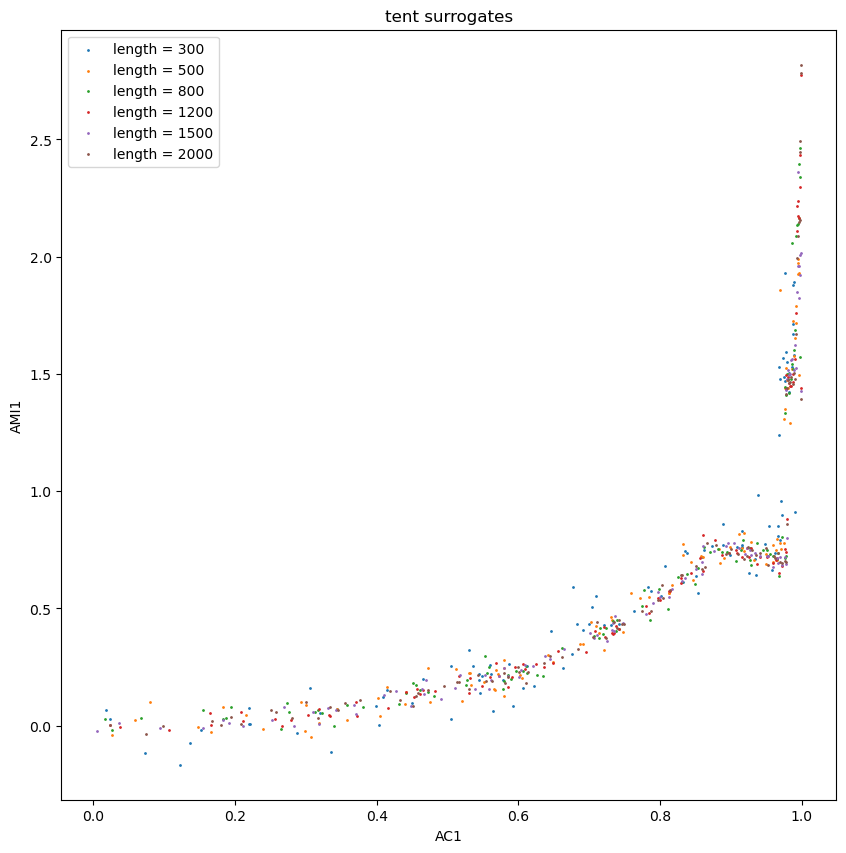

In [83]:
tentAllSurrogatesAC1 = np.array([
    tentSurrogatesAC1_300,
    tentSurrogatesAC1_500,
    tentSurrogatesAC1_800,
    tentSurrogatesAC1_1200,
    tentSurrogatesAC1_1500,
    tentSurrogatesAC1_2000
])
tentAllSurrogatesAMI1 = np.array([
    tentSurrogatesAMI1_300,
    tentSurrogatesAMI1_500,
    tentSurrogatesAMI1_800,
    tentSurrogatesAMI1_1200,
    tentSurrogatesAMI1_1500,
    tentSurrogatesAMI1_2000
])

logisticAllSurrogatesAC1 = np.array([
    logisticSurrogatesAC1_300,
    logisticSurrogatesAC1_500,
    logisticSurrogatesAC1_800,
    logisticSurrogatesAC1_1200,
    logisticSurrogatesAC1_1500,
    logisticSurrogatesAC1_2000
])
logisticAllSurrogatesAMI1 = np.array([
    logisticSurrogatesAMI1_300,
    logisticSurrogatesAMI1_500,
    logisticSurrogatesAMI1_800,
    logisticSurrogatesAMI1_1200,
    logisticSurrogatesAMI1_1500,
    logisticSurrogatesAMI1_2000
])
lengths = [300, 500, 800, 1200, 1500, 2000]
plt.figure(figsize=(10, 10))
for i in range(len(lengths)):
    plt.scatter(np.abs(tentAllSurrogatesAC1[i]), tentAllSurrogatesAMI1[i], s=1, label="length = {}".format(lengths[i]))
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.title("tent surrogates")
plt.legend()
plt.show()





In [84]:
# def add_noise_with_snr(signal, snr_dB):
#     signal_power = np.mean(np.square(signal))
#     snr_linear = 10 ** (snr_dB / 10)
#     noise_power = signal_power / snr_linear

#     noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
#     noisy_signal = signal + noise
#     return noisy_signal

In [108]:
def db2mag(db):
    return 10 ** (db / 20)

def add_noise_with_snr_v2(signal, snr_dB):
    noise_std = np.std(signal) / db2mag(snr_dB)
    noise = np.random.randn(len(signal)) * noise_std
    noisy_signal = signal + noise
    return noisy_signal

In [110]:
# now add mesurement noise
x_start = 0.1
series_length = 1000
tent_a_num = 100
tent_logistic_num = 100

param_range_tent = np.linspace(1.001, 1.999, tent_a_num)
param_range_logistic = np.linspace(3.57, 4, tent_logistic_num)

tent_full_data = np.array([
    np.fromiter(datasets.tent_map(x_start, series_length, mu), dtype="float32")
    for mu in param_range_tent
])
logistic_full_data = np.array([
    np.fromiter(datasets.logistic_map(x_start, series_length, r), dtype="float32")
    for r in param_range_logistic
])

tent_full_data = tent_full_data[:, 200:]
logistic_full_data = logistic_full_data[:, 200:]


tentLambdas = np.log(param_range_tent, where=param_range_tent > 0)
tentLambdas[np.where(param_range_tent <= 0)] = np.nan
tentChaoticIdx = np.where(tentLambdas > 0)

logisticLambdas =np.array([
      np.mean(np.log(abs(r - 2 * r * x[np.where(x != 0.5)])))
      for x, r in zip(logistic_full_data, param_range_logistic)
    ])
logisticChaoticIdx = np.where(logisticLambdas > 0)

tentParamRangeChaotic = param_range_tent[tentChaoticIdx]
# tentAC1Chaotic = tentAC1[tentChaoticIdx]

logisticParamRangeChaotic = param_range_logistic[logisticChaoticIdx]
# logisticAC1Chaotic = logisticAC1[logisticChaoticIdx]
# tentAMI1Chaotic = tentAMI1[tentChaoticIdx]
# logisticAMI1Chaotic = logisticAMI1[logisticChaoticIdx]

# book keeping
# tentAC1 = tentAC1
# logisticAC1 = logisticAC1

# tentAMI1 = tentAMI1
# logisticAMI1 = logisticAMI1

# add measurement noise to the data, change the noise level each iteration

noisy_tent_full_data = np.zeros_like(tent_full_data)
noisy_tent = []
snr = range(-5,25,5)
for snr_idx in range(len(snr)):
    for i in trange(len(tent_full_data)):
        noisy_tent_full_data[i] = add_noise_with_snr(tent_full_data[i], snr[snr_idx])
    noisy_tent.append(noisy_tent_full_data)

noisy_logistic_full_data = np.zeros_like(logistic_full_data)
noisy_logistic = []
for snr_idx in range(len(snr)):
    for i in trange(len(logistic_full_data)):
        noisy_logistic_full_data[i] = add_noise_with_snr(logistic_full_data[i], snr[snr_idx])
    noisy_logistic.append(noisy_logistic_full_data)





  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [112]:
# compute the surrogates for each noise level
tentSurrogatesAC1noisy = []
tentSurrogatesAMI1noisy = []
# logisticSurrogatesAC1 = []
# logisticSurrogatesAMI1 = []

for i in trange(len(noisy_tent)):
    atthisnoise = noisy_tent[i]
    tentSurrogates_temp = np.array([SS_iter_surro(series, max_it=2000) for series in tqdm(atthisnoise)])
    tentSurrogatesAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in tentSurrogates_temp
    ])

    tentSurrogatesAMI1 = automutual_info(tentSurrogates_temp, 1, 3)
    tentSurrogatesAC1noisy.append(tentSurrogatesAC1)
    tentSurrogatesAMI1noisy.append(tentSurrogatesAMI1)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Processing:   0%|          | 0/100 [00:00<?, ?it/s]

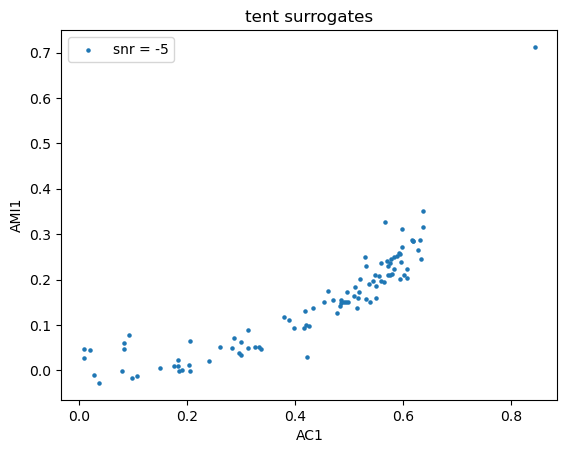

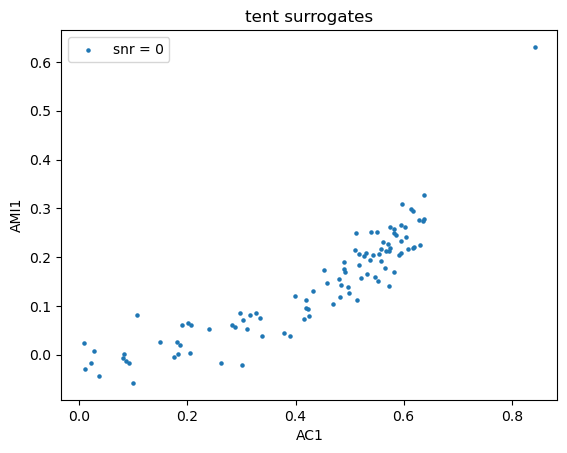

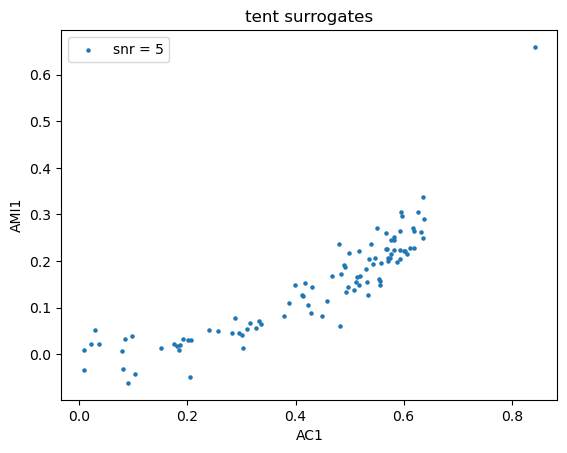

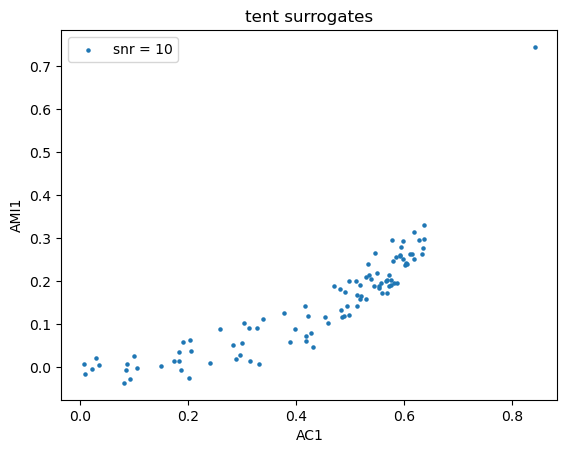

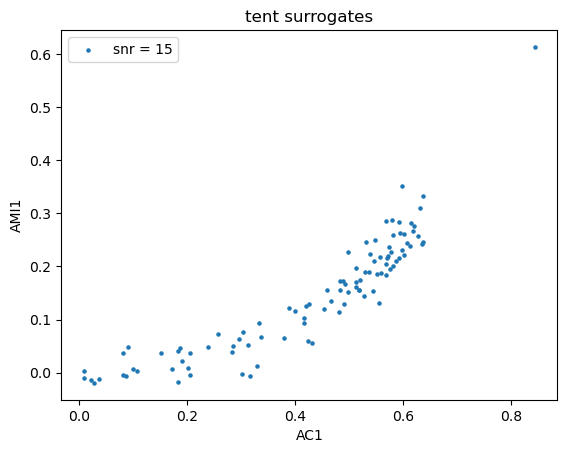

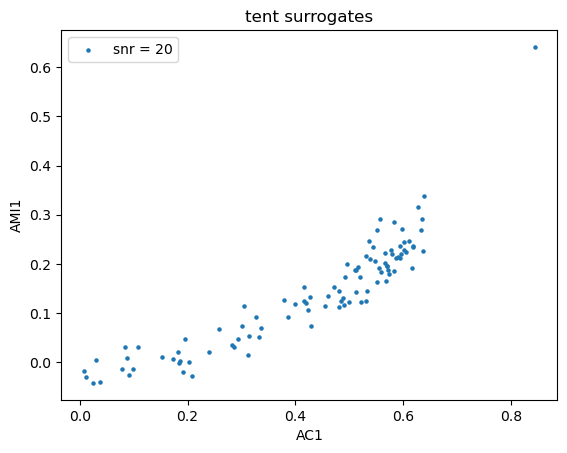

In [113]:

for i in range(len(snr)):
    plt.figure()
    plt.scatter(np.abs(tentSurrogatesAC1noisy[i]), tentSurrogatesAMI1noisy[i], s=5, label="snr = {}".format(snr[i]))
    plt.xlabel("AC1")
    plt.ylabel("AMI1")
    plt.title("tent surrogates")
    plt.legend()

In [92]:
for i in range(-5,25, 5):
    print(i)

-5
0
5
10
15
20


  0%|          | 0/500 [00:00<?, ?it/s]

Processing:   0%|          | 0/500 [00:00<?, ?it/s]

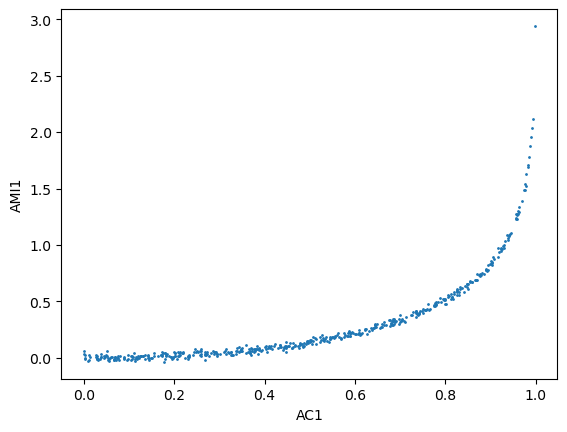

In [4]:
a_num = 500

lag1para = np.linspace(0, 1, a_num)
ARpara = [np.r_[1, -arparams] for arparams in lag1para]
series_length = 2000

# Generate data
ARmatrix = np.array([ArmaProcess(ar, [1]).generate_sample(nsample=series_length) for ar in tqdm(ARpara)])
ARmatrixAMI1 = automutual_info(ARmatrix, 1, 3)
ARmatrixAC1 = np.array([
    acf(series, nlags=1)[1]
    for series in ARmatrix
])

plt.figure()
plt.scatter(np.abs(ARmatrixAC1), ARmatrixAMI1, s=1)
plt.xlabel("AC1")
plt.ylabel("AMI1")
plt.show()

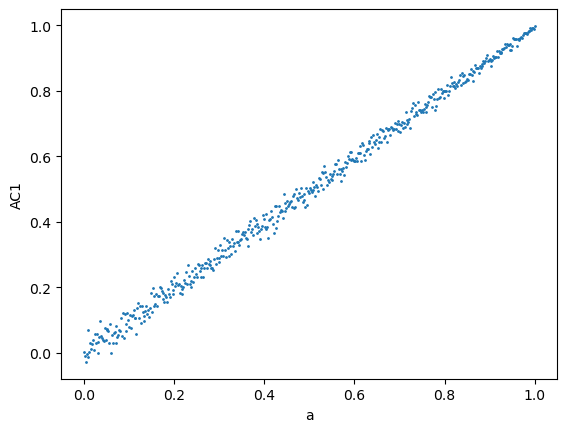

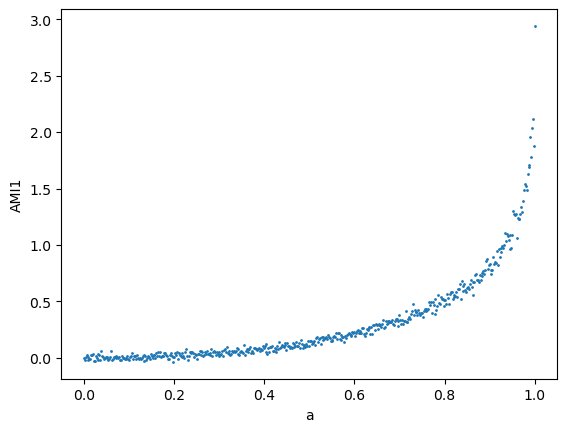

In [8]:
plt.figure()
plt.scatter(lag1para, ARmatrixAC1, s=1)
plt.xlabel("a")
plt.ylabel("AC1")
plt.show()
plt.figure()
plt.scatter(lag1para, ARmatrixAMI1, s=1)
plt.xlabel("a")
plt.ylabel("AMI1")
plt.show()